In [165]:
import numpy as np
import json
import matplotlib.pyplot as plt
import os

mc_folder = "/work/creissel/GPUanalysis/hepaccelerate/massfit_v1/"
data_folder = "/work/creissel/GPUanalysis/hepaccelerate/fix2_data/"

sample_list = [
    "ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8",
    "ttHToNonbb_M125_TuneCP5_13TeV-powheg-pythia8",
    "TTTo2L2Nu_TuneCP5_PSweights_13TeV-powheg-pythia8",
    "TTToHadronic_TuneCP5_PSweights_13TeV-powheg-pythia8",
    "TTToSemiLeptonic_TuneCP5_PSweights_13TeV-powheg-pythia8",
]

import matplotlib 
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12)

In [166]:
def merge_json_output(samples):
    
    merge = {}
    for indx,s in enumerate(samples):
        with open(s) as json_file:
            data = json.load(json_file)
        
        for k1 in data.keys():
            if indx == 0:
                merge[k1] = {}
            for k2 in data[k1].keys():
                if k2 == "contents" and indx != 0:
                    merge[k1][k2] = [sum(x) for x in zip(merge[k1][k2], data[k1][k2])]
                else:
                    merge[k1][k2] = data[k1][k2]
    return merge
        

In [174]:
mc = merge_json_output([os.path.join(mc_folder, "out_"+sample+".json") for sample in sample_list if sample.startswith("TT")])
#mc = {}
for sample in sample_list:
    if sample.startswith("tt"):
        with open(os.path.join(mc_folder, "out_"+sample+".json")) as json_file:
            mc.update(json.load(json_file))


output_data = [data_folder + "out_Run2017" + i + "_SingleElectron.json" for i in ["B", "C", "D", "E", "F"]]
output_data += [data_folder + "out_Run2017" + i + "_SingleMuon.json" for i in ["B", "C", "D", "E", "F"]]
#output_data += [data_folder + "out_Run2017" + i + "_DoubleMuon.json" for i in ["B", "C", "D", "E", "F"]]
#output_data += [data_folder + "out_Run2017" + i + "_DoubleEG.json" for i in ["B", "C", "D", "E", "F"]]
#output_data += [data_folder + "out_Run2017" + i + "_MuonEG.json" for i in ["B", "C", "D", "E", "F"]]

data = merge_json_output(output_data)

In [175]:
var_names = {
#    "nbtags": "DeepCSV btag multiplicity",
    "njets" : "jet multiplicity",
#    "leading_jet_pt" : "leading jet pt [GeV]",
#    "leading_lepton_pt" : "leading lepton pt [GeV]",
    #"genWeights" : "genWeights",
    #"nElectrons" : "number of electrons",
    #"nMuons" : "number of muons",
    "DNN": "dijet mass [GeV]",
    "DNN_zoom": "dijet mass (zoom) [GeV]",
    "nleps": "Number of leptons",
#    "nfatjets": "fat jet multiplicity",
#    "nbbtags": "H->bb tag multiplicity",
#    "leading_fatjet_pt": "leading fat jet pt [GeV]",
#    "leading_fatjet_eta": "leading fat jet eta",
#    "leading_fatjet_mass": "leading fat jet mass [GeV]",
#    "leading_jet_eta": "leading jet eta",
#   "leading_lepton_eta" : "leading lepton eta",
#   "higgs_pt": "Higgs pt [GeV]",
#    "higgs_eta": "Higgs eta",
#    "top_pt": "top pt [GeV]",
#    "top_eta": "top eta",
#    "leading_bjet_pt" : "leading jet pt [GeV]",
#    "subleading_bjet_pt" : "subleading bjet pt [GeV]",
#    "subleading_fatjet_pt" : "subleading fat jet pt [GeV]",
#    "subleading_fatjet_mass" : "subleading fat jet mass [GeV]",
}

processes = ["ttHTobb", "ttHToNonbb", "ttlf", "ttbb", "tt2b","ttb", "ttcc"]
#processes = ["ttHTobb", "ttlf", "ttbb", "tt2b","ttb", "ttcc"]
#processes = ["ttHTobb"]

process_names = {
    "ttHTobb" : "tt+H(bb)",
    "ttHToNonbb": "tt+H(non-bb)",
    "ttlf" : "tt+light",
    "ttbb" : "tt+bb",
    "tt2b" : "tt+2b",
    "ttb" : "tt+b",
    "ttcc" : "tt+cc",
    
}

colors = {
    "ttlf": (251, 102, 102),
    "ttcc": (204, 2, -0),
    "ttb": (153, 51, 51),
    "ttbb": (102, 0, 0),
    "tt2b": (80, 0, 0),
    "ttHTobb": (44, 62, 167),
    "ttHToNonbb": (90, 115, 203),
}

for cn, c in colors.items():
    colors[cn] = (c[0]/255.0, c[1]/255.0, c[2]/255.0)
    
cat = "sl_jge4_tge2"


In [176]:
def plot_mc(var, data, name, bottom, process, normalize):
    
    bins = data[var]["edges"][:-1]
    counts = data[var]["contents"]
    yerr = data[var]["contents_w2"]
        
    integral = sum(counts)
    width = bins[1] - bins[0]
    

    if normalize:
        counts = [c/float(integral) for c in counts]
        hist = plt.step(bins, counts, label=name, color=colors[process], where="pre", zorder = 1000)
    else:    
        hist = plt.bar(bins, counts, width=width, bottom=bottom, align="edge", label=name + " ({0})".format(round(integral, 1)), color=colors[process], edgecolor=colors[process], zorder = 1000)
        #hist = plt.bar(bins, counts, yerr=yerr, width=width, align="center", label=dataset + " ({0})".format(round(integral, 2)))
    
    if process == "ttHTobb" and not normalize:
        bins = data[var]["edges"][1:]
        hist = plt.step(bins, [c*1 for c in counts], label="tt+H(bb) x 50", color=colors[process], where="pre", zorder=1001)
        
    return plt.bar, counts, data[var]["edges"]

In [177]:
def plot_data(var, data):
    
    bins = data[var]["edges"][:-1]
    counts = data[var]["contents"]
    yerr = data[var]["contents_w2"]
        
    integral = sum(counts)
    width = bins[1] - bins[0]
    
    bin_centers = [i+width/2. for i in data[var]["edges"][:]]    

    #hist = plt.step(bins, counts, where="post", label="data ({0})".format(round(integral, 1)), color="k", zorder = 1001, markeredgecolor=None)
    hist = plt.plot(bin_centers, counts+[0.], "-o", drawstyle="steps-mid", label="data ({0})".format(round(integral, 1)), color="k", zorder = 1001)
    plt.xlim([data[var]["edges"][0], data[var]["edges"][-1]])
    #hist = plt.bar(bins, counts, yerr=yerr, width=width, align="center", label=dataset + " ({0})".format(round(integral, 2)))
        
    return plt.plot, counts

In [178]:
def plot_histogram(var, processes, mc, data, cat, normalize=False):
    
    
    fig = plt.figure(figsize=(6,6))
    
    # main plot
    bottom = None
    
    a1 = plt.axes([0.0,0.22,1.0,0.8])
    #a1.get_xaxis().set_visible(False)

    plt.grid(True, axis='y', zorder=0)
    for p in processes:
        _, counts, bins = plot_mc("hist_" + p + "_" + cat + "_" + var, mc, process_names[p], bottom, p, normalize)
        if processes.index(p) == 0:
            bottom = [0.0 for c in counts]
        bottom = [sum(x) for x in zip(bottom, counts)]   
    
    if not data == None:
        _, counts_data = plot_data("hist_data_" + cat + "_" + var, data)
        
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=14)
    #plt.yscale('log')
    if var == "njets":
        plt.xlim([0,14])
        plt.yscale('log')
        plt.ylim([1,10**8])
        
    if var == "nbtags":
        plt.xlim([0,6])
        plt.yscale('log')
        plt.ylim([1,10**8])

    plt.ylabel("events / bin", fontsize=18)
    plt.title(
        r"$\mathbf{CMS}$ private work",
        fontsize=16, x=0.0, ha="left", y=1.03, va="top")
    ax = plt.gca()
    plt.text(0.99, 0.99,
        "2017 pp $41.5\ \mathrm{fb}^{-1}\ \mathrm{(13\ TeV)}$",
              fontsize=12, ha="right", va="bottom", transform=ax.transAxes)
    if data == None:
        plt.xlabel(var_names[var], fontsize=18)
    
    if not data == None:
        # ratio plot
        a2 = plt.axes([0.0,0.0, 1.0, 0.18], sharex=a1)
        plt.xlabel(var_names[var], fontsize=18)
        plt.grid(True, axis='x', zorder=0)
        plt.ylabel(r"$\frac{\mathrm{data}}{\mathrm{pred.}}$", fontsize=16)
        plt.axhline(1.0, color="gray")
    
    
        ratio = [x/y if y > 0 else 1. for x, y in zip(counts_data, bottom)] + [1.0]
        width = bins[1] - bins[0]
        plt.plot(bins, ratio, "k-", drawstyle="steps-post", zorder = 1001)
    
        a2.set_ylim(0.75, 1.25)
        ticks = a1.get_xticks()
        a2.set_xticks(ticks)
    #plt.savefig('plots/fancy_overlap_selection/'+var+'.pdf', bbox_inches='tight')
    plt.show()

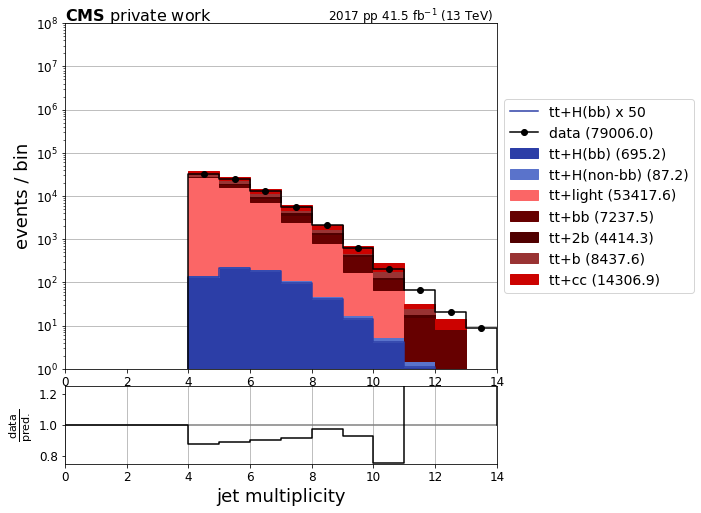

KeyError: 'hist_data_sl_jge4_tge3_DNN'

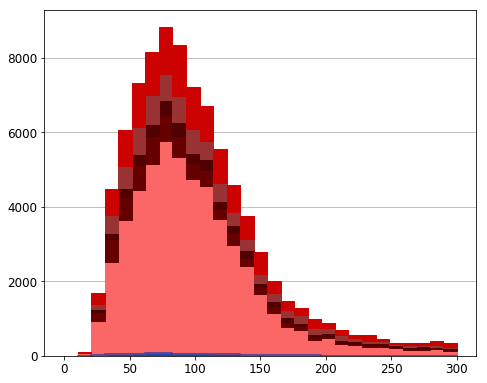

In [179]:
cat = "sl_jge4_tge3"
for var in var_names.keys():
    plot_histogram(var, processes, mc, data, cat)

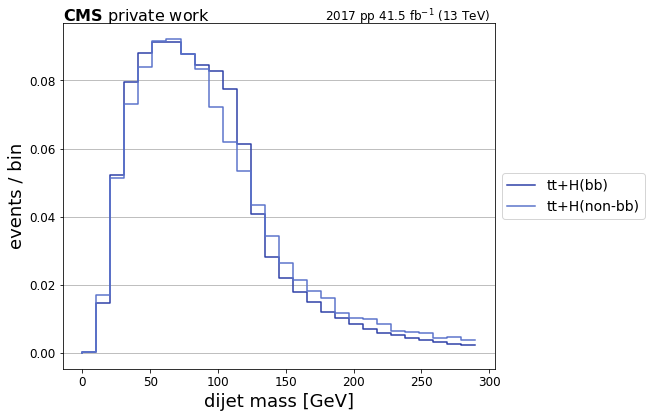

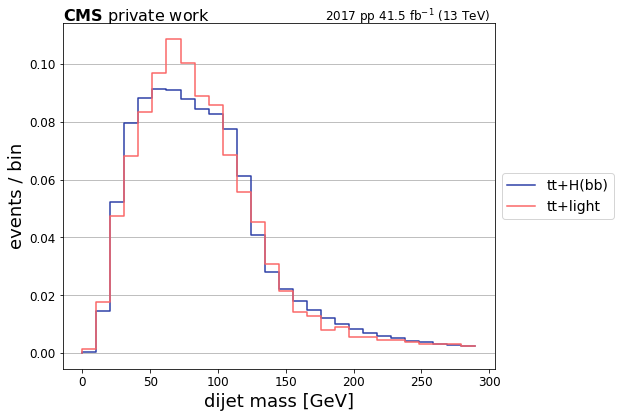

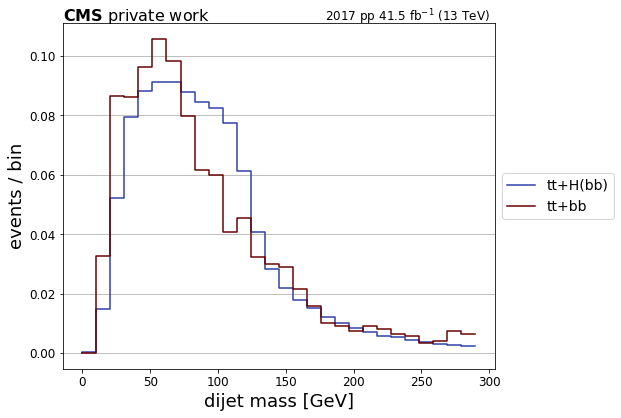

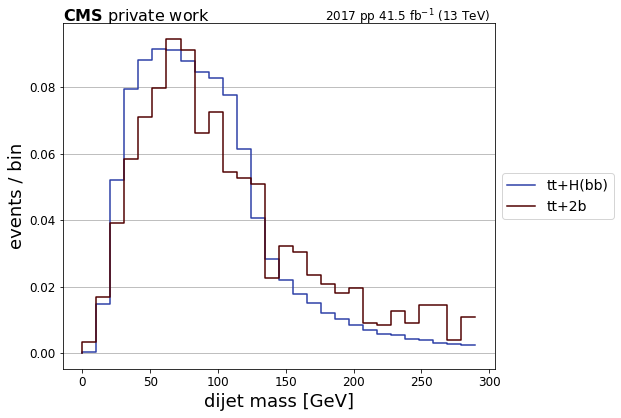

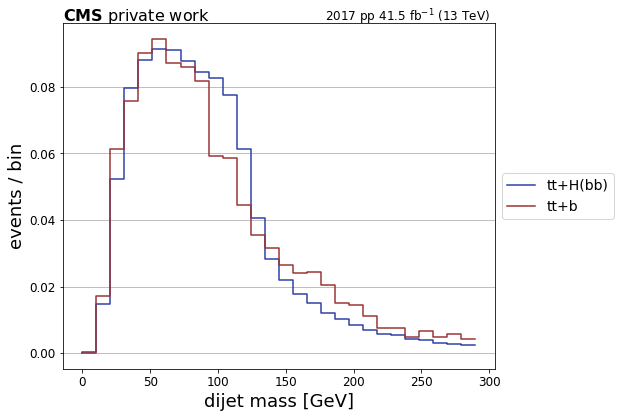

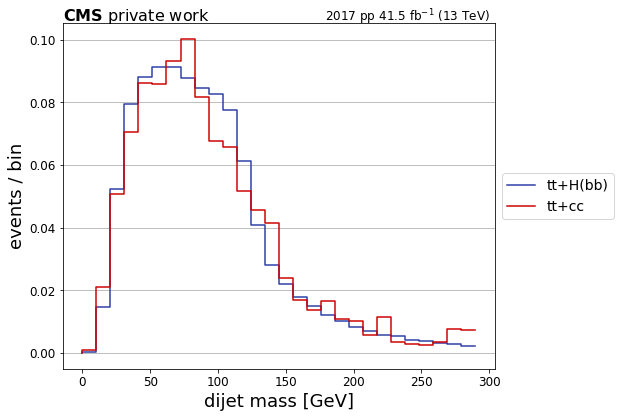

In [158]:
cat = "sl_jge4_tge3"
for var in ["DNN"]:
    for p in processes[1:]:
        plot_histogram(var, ["ttHTobb", p], mc, None, cat, True)

# Calculation of stat. only result

In [160]:
def likelihood(mu, data_i, s_i, b_i):
    b_i[b_i < 0] = 0.0
    s_i[s_i < 0] = 0.0

    sel = ((s_i>0) & (b_i>0))
    
    ret = data_i[sel] * np.log(np.full(data_i[sel].shape[0], mu)*s_i[sel] + b_i[sel]) - (mu*s_i[sel] + b_i[sel])
    #ret = data_i * np.log(np.full(data_i.shape[0], mu)*s_i + b_i) - (mu*s_i + b_i)
    return -np.sum(ret)

In [161]:
def make_fake_data(data, var, processes, cat):
    
    # calculate total MC prediction
    for p in processes:
        if processes.index(p) == 0:
            counts = data["hist_" + p + "_" + cat + "_" + var]["contents"]
        else:
            counts = [x + y for x, y in zip(counts, data["hist_" + p + "_" + cat + "_" + var]["contents"])]
    
    return counts

In [162]:
def stat_fit(data, var, processes, cat):
    
    fake_data = np.asarray(make_fake_data(data, var, processes, cat))
    sigs = ["ttHTobb", "ttHToNonbb"]
    for p in sigs:
        if sigs.index(p) == 0:
            sig_tot = data["hist_" + p + "_" + cat + "_" + var]["contents"]
        else:
            sig_tot = [x + y for x, y in zip(sig_tot, data["hist_" + p + "_" + cat + "_" + var]["contents"])]
    sig = np.asarray(sig_tot)
    print(sig.shape)
    
    bkgs = ["ttlf", "ttcc", "ttb", "tt2b", "ttbb"]
    for p in bkgs:
        if bkgs.index(p) == 0:
            bkg_tot = data["hist_" + p + "_" + cat + "_" + var]["contents"]
        else:
            bkg_tot = [x + y for x, y in zip(bkg_tot, data["hist_" + p + "_" + cat + "_" + var]["contents"])]
    bkg_tot = np.asarray(bkg_tot)
    print(bkg_tot.shape)
    print(fake_data.shape)
    
    import scipy.optimize as optimize
    mu0 = 0.0
    res = optimize.minimize(likelihood, mu0, (fake_data, sig, bkg_tot), bounds = [(None,None)])

    # Error of estimator
    err = lambda mu: likelihood(mu, fake_data, sig, bkg_tot)-(likelihood(res.x, fake_data, sig, bkg_tot)+0.5)

    down = res.x - optimize.fsolve(err,(res.x - 3.0))[0]
    up = optimize.fsolve(err,(res.x + 0.01))[0] - res.x

    print("Best fit:", res.x[0], "-", round(down[0], 4), "+", round(up[0], 4))
    

In [163]:
cat = "sl_jge4_tge3"
stat_fit(mc, "DNN", processes, cat)

(29,)
(29,)
(29,)
Best fit: 0.9999999999999999 - 0.3815 + 0.3824


# ROC curve

In [106]:
def ROC(data, processes, cat, var):
    
    sigs = ["ttHTobb", "ttHToNonbb"]
    for p in sigs:
        if sigs.index(p) == 0:
            sig_tot = data["hist_" + p + "_" + cat + "_" + var]["contents"]
        else:
            sig_tot = [x + y for x, y in zip(sig_tot, data["hist_" + p + "_" + cat + "_" + var]["contents"])]
    sig = np.asarray(sig_tot)
    
    bkgs = ["ttlf", "ttcc", "ttb", "tt2b", "ttbb"]
    for p in bkgs:
        if bkgs.index(p) == 0:
            bkg_tot = data["hist_" + p + "_" + cat + "_" + var]["contents"]
        else:
            bkg_tot = [x + y for x, y in zip(bkg_tot, data["hist_" + p + "_" + cat + "_" + var]["contents"])]
    bkg_tot = np.asarray(bkg_tot)
    
    nsig = sum(sig_tot)
    nbkg = sum(bkg_tot)
    bkg_tot = [x/nbkg for x in bkg_tot]
    sig_tot = [x/nsig for x in sig_tot]

    fpr = np.cumsum(bkg_tot)
    tpr = np.cumsum(sig_tot)
    
    from sklearn.metrics import auc
    roc_auc = auc(fpr, tpr, reorder=True)
    if roc_auc < 0.5:
        roc_auc = 1 - roc_auc
    
    fig = plt.figure(figsize=(6,6))
    plt.plot([0, 1], [0, 1], color='k', linestyle='--')
    plt.plot(tpr, fpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.legend(loc="lower right", fontsize=16)
    
    return roc_auc
    

/work/creissel/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


0.5033072685170751

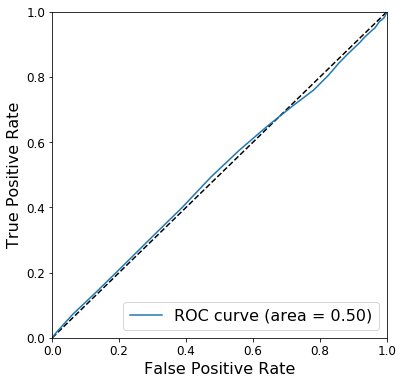

In [107]:
cat = "sl_jge6_t3"
ROC(mc, processes, cat, "DNN")

In [108]:
roc = 0
for p in ["ttH", "ttbb", "tt2b", "ttb", "ttcc", "ttlf"]:
    roc += ROC(mc, processes, cat, "DNN_ROC_" + p)
print(roc/6.)

KeyError: 'hist_ttHTobb_sl_jge6_t3_DNN_ROC_ttH'

# Plot confusion matrix

In [109]:
def calculate_confusion_matrix(data, process):
    pred = []
    for true_p in ["ttHTobb", "ttbb", "tt2b","ttb", "ttcc", "ttlf"]:
        ntot = sum(data["hist_" + true_p + "_" + cat + "_nleps"]["contents"])
        for pred_p in ["ttH", "ttbb", "tt2b", "ttb", "ttcc", "ttlf"]:
            n_pred = sum(data["hist_" + true_p + "_" + cat + "_DNN_ROC_" + pred_p]["contents"])/ntot
            pred.append(n_pred)
                   
    confusion_matrix = np.asarray(pred)
    cm = confusion_matrix.reshape((6,6))   
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap = plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=["ttHbb", "ttbb", "tt2b", "ttb", "ttcc", "ttlf"], yticklabels=["ttHbb", "ttbb", "tt2b", "ttb", "ttcc", "ttlf"],
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [110]:
cat = "sl_j4_tge3"
calculate_confusion_matrix(mc, processes)

KeyError: 'hist_ttHTobb_sl_j4_tge3_nleps'